In [60]:
import json
import chess.pgn
import os
import re
import pandas as pd
import numpy as np
import pickle
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#file = r'C:\Users\Giorgio\Documents\Python Scripts\Scacchi chessbase DB\data\chessbase\results_elo_date.pkl'
#with open(file, 'rb') as pickle_file:
#    df = pickle.load(pickle_file)
#df

In [3]:
PATH = r'C:\Users\Giorgio\Documents\Python Scripts\Scacchi chessbase DB\data\chessbase'
result = [y for x in os.walk(PATH) for y in glob(os.path.join(x[0], '*date.pkl'))]
result
columns_of_interest = ['Result', 'BlackElo', 'WhiteElo', 'Date', 'ECO']
df_total = pd.DataFrame(columns=columns_of_interest)
for pkl_path in result:
    with open(pkl_path, 'rb') as pickle_file:
        df = pickle.load(pickle_file)
        df_total = pd.concat([df_total, df], axis = 0).reset_index(drop=True)
df_total

,Result,BlackElo,WhiteElo,Date,ECO
0,1-0,NaN,NaN,????.??.??,NaN
1,1-0,NaN,NaN,????.??.??,NaN
2,1-0,NaN,NaN,1515.??.??,A00
3,1-0,NaN,NaN,1560.??.??,C30
4,1-0,NaN,NaN,1572.??.??,C40
...,...,...,...,...,...
7623696,1/2-1/2,107,1413,2015.12.06,A01
7623697,1/2-1/2,1370,83,2015.12.06,C18
7623698,0-1,108,95,2015.12.06,B02
7623699,0-1,1154,NaN,2015.12.06,C34


In [4]:
df = df_total.copy()
df['WhiteResult'] = df['Result']
df = df.replace({'WhiteResult' : { '1-0' : 1, '1/2-1/2' : 0.5, '0-1' : 0 }})
df['Year'] = df['Date'].str[:4]
df.drop(columns=['Result', 'Date'], inplace=True)

In [5]:
#clean
df = df.dropna()
df = df[df['Year']!='????']
df = df[df['WhiteResult']!='*']
df = df.astype({"BlackElo": int, "WhiteElo": int, "WhiteResult": float, "Year": int})
df = df[df['BlackElo']>=1500]
df = df[df['WhiteElo']>=1500]
df['avg_elo'] = df[['WhiteElo', 'BlackElo']].mean(axis=1)
df['diff_elo'] = df['WhiteElo'] - df['BlackElo']
df.drop(columns=['WhiteElo', 'BlackElo'], inplace=True)

In [6]:
df

,ECO,WhiteResult,Year,avg_elo,diff_elo
195065,B05,0.5,1970,2216.0,96
195069,B49,1.0,1970,2236.0,152
195071,D00,0.0,1970,2216.0,-64
195073,E06,0.0,1970,2208.0,-112
195076,C95,1.0,1970,2212.0,200
...,...,...,...,...,...
7623568,C67,0.5,2015,2790.5,25
7623569,A34,0.5,2015,2773.0,16
7623570,B51,1.0,2015,2790.5,87
7623571,C67,0.5,2015,2798.0,-10


In [7]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,WhiteResult,Year,avg_elo,diff_elo
count,4924579.00000,4924579.00000,4924579.00000,4924579.00000
mean,0.53839,2007.02591,2186.62069,2.87973
std,0.41014,8.18389,244.08644,198.60975
min,0.00000,1929.00000,1500.00000,-1205.00000
25%,0.00000,2002.00000,2020.00000,-126.00000
50%,0.50000,2009.00000,2212.50000,2.00000
75%,1.00000,2013.00000,2370.00000,132.00000
max,1.00000,2018.00000,2849.00000,1269.00000


<AxesSubplot: xlabel='Year', ylabel='Density'>

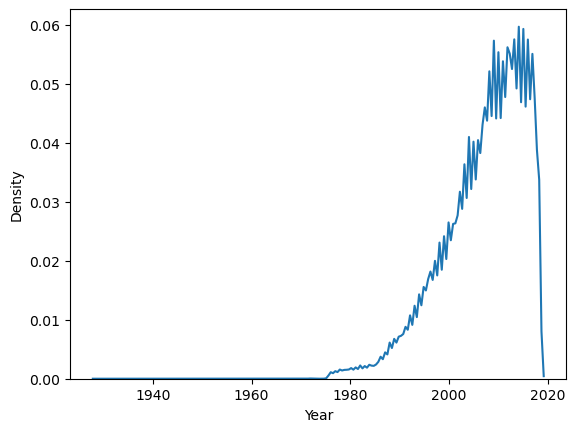

In [8]:
sns.kdeplot(df['Year'])

In [9]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

#X, y = normalized_df_lic[['WhiteElo',	'BlackElo',	'avg_elo',	'diff_elo']], df_lic[['WhiteResult']]
X, y = df[['avg_elo','diff_elo']], df[['WhiteResult']]

# define model
model = XGBRegressor()
# fit model
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [10]:
id = 7623568
yhat = model.predict(np.asarray(X.loc[[id]]))
print(df.loc[[id]], yhat)

         ECO  WhiteResult  Year  avg_elo  diff_elo
7623568  C67          0.5  2015   2790.5        25 [0.58390445]


In [11]:
model.feature_importances_

array([0.01269338, 0.98730665], dtype=float32)

In [12]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [13]:
yhat = regr.predict(X.loc[[id]])
print(df.loc[[id]], yhat)

         ECO  WhiteResult  Year  avg_elo  diff_elo
7623568  C67          0.5  2015   2790.5        25 [[0.57764894]]


C:\Users\Giorgio\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'z')

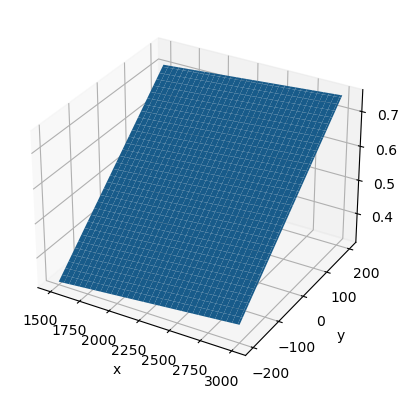

In [15]:
#https://plotly.com/python/ml-regression/
#https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
import plotly.graph_objects as go
xrange = np.linspace(1500, 3000, 101)#np.arange(1500, 3000, 50)
yrange = np.linspace(-200, 200, 101)#np.arange(-200, 200, 10)
xx, yy = np.meshgrid(xrange, yrange)

# Run model
pred = regr.predict(np.c_[xx.ravel(), yy.ravel()])
pred = pred.reshape(xx.shape)

# Generate the plot
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(xx, yy, pred, 50)#, cmap='binary')
ax.plot_surface(xx, yy, pred)#, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.plot(x,0.5, color='purple', alpha=0.1)


In [16]:
def_pred = pd.DataFrame(pred, index=xrange, columns=yrange)
def_pred[abs(def_pred-0.5)<0.02]

,-200.0,-196.0,-192.0,-188.0,-184.0,-180.0,-176.0,-172.0,-168.0,-164.0,...,164.0,168.0,172.0,176.0,180.0,184.0,188.0,192.0,196.0,200.0
1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1515.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1530.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1545.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2955.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2970.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


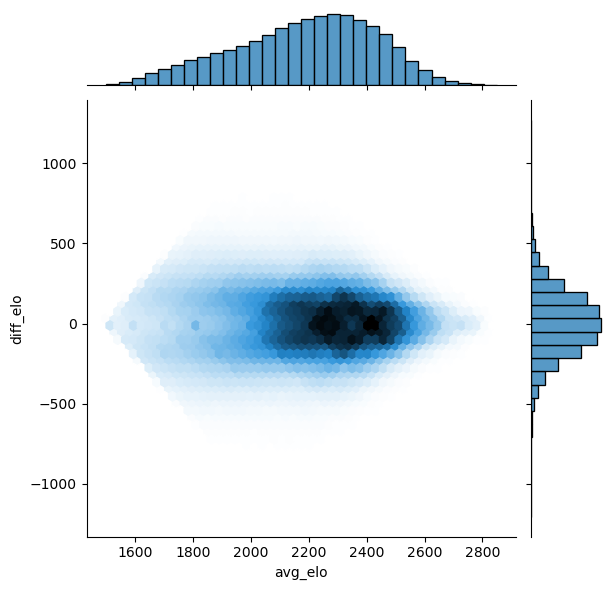

In [17]:
# Custom the histogram:
sns.jointplot(x=df["avg_elo"], y=df["diff_elo"], kind='hex', marginal_kws=dict(bins=30, fill=True))
plt.show()

In [23]:
from scipy import stats

bins=100
x_bin = np.linspace(1500, 2900, num=15, endpoint=True, retstep=False, dtype=None, axis=0)
y_bin = np.linspace(-1000, 1000, num=70, endpoint=True, retstep=False, dtype=None, axis=0)
H, xedges, yedges, binnumber = stats.binned_statistic_2d(df["avg_elo"], df["diff_elo"], 
                                                         values = df["WhiteResult"], statistic='mean', 
                                                         #bins = 30) 
                                                         bins = [x_bin, y_bin])

<AxesSubplot: >

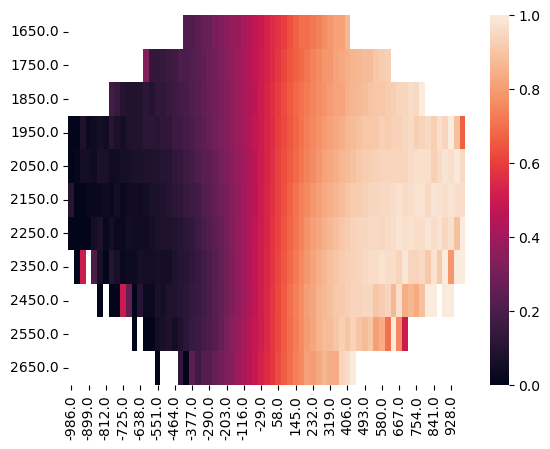

In [33]:
x_middle_rounded=[]
for ii in range(0,len(xedges)-1):
    x_middle_rounded.append(np.round((xedges[ii]+xedges[ii+1])/2))
y_middle_rounded=[]
for ii in range(0,len(yedges)-1):
    y_middle_rounded.append(np.round((yedges[ii]+yedges[ii+1])/2))
HH = pd.DataFrame(H, index=x_middle_rounded, columns=y_middle_rounded)
HH = HH.loc[1650:2650]
sns.heatmap(HH)#, 
           #xticklabels=1, yticklabels=1)

<AxesSubplot: >

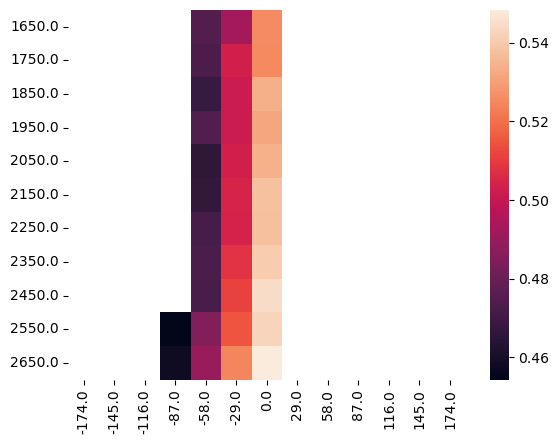

In [34]:
HHH = HH.copy()
HHH[abs(HHH-0.5)>0.05]=np.NaN
HHHH = HHH.loc[:, (abs(HHH.columns)<200)]
sns.heatmap(HHHH)

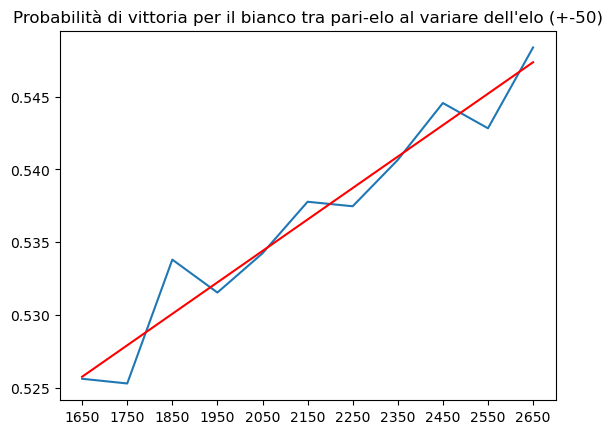

In [58]:
xx=HH.index
yy=HH.loc[:, 0]

slope, intercept, r, p, std_err = stats.linregress(xx, yy)

def myfunc(x):
  return slope * x + intercept
mymodel = list(map(myfunc, xx))

plt.plot(xx, yy) #plt.scatter(xx, yy)
plt.plot(xx, mymodel, 'r')#, label='y={:.5f}x+{:.5f}'.format(slope,intercept))
plt.title("Probabilità di vittoria per il bianco tra pari-elo al variare dell'elo (+-50)")
plt.xticks(xx)
#plt.legend(fontsize=9)
plt.show()

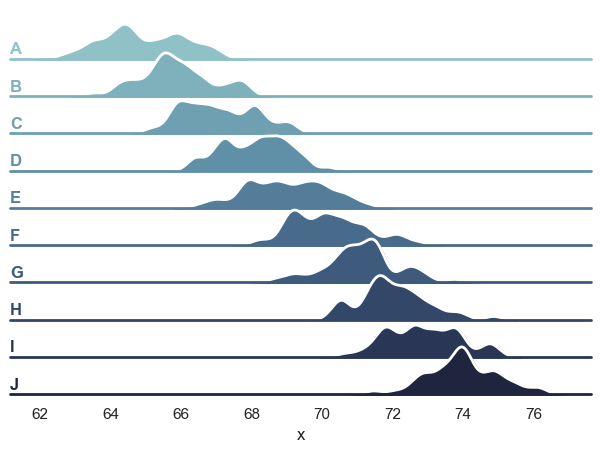

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [62]:
df

,x,g
0,64.038123,A
1,66.147050,B
2,66.370011,C
3,68.791019,D
4,70.583534,E
...,...,...
495,69.358022,F
496,72.212877,G
497,70.474247,H
498,73.251022,I
